### Obtención de los datos

Para usar la API de kaggle, tenemos que cargar el archivo `kaggle.json` en la ruta `/root/.config/kaggle`, este archivo se obtiiene del API Token desde tu cuenta de Kagle `https://www.kaggle.com/settings` en la opción ``Create Legacy API Key``

In [1]:
# Importar Librerias
import pandas as pd
import kaggle
import matplotlib.pyplot as plt

Para obtener los datasets a analizar para nuestro trabajo, usaremos un conjunto de tablas utilizando la API de Kaggle

In [2]:
# Obtenemos los dataset con la API de Kaggle
kaggle.api.dataset_download_files(
    "olistbr/brazilian-ecommerce",
    path="data",
    unzip=True
)

Dataset URL: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce


In [3]:
# Obtenemos los dataframes a analizar

order_payments = pd.read_csv("data/olist_order_payments_dataset.csv")
orders = pd.read_csv("data/olist_orders_dataset.csv")
order_items = pd.read_csv("data/olist_order_items_dataset.csv")
products = pd.read_csv("data/olist_products_dataset.csv")
categories = pd.read_csv("data/product_category_name_translation.csv")

A continuación revisamos las tablas buscando por información relevante para nuestro análisis, como la cantidad de ventas de ciertos tipos de productos en un espacio temporal.

In [4]:
order_payments.describe()

,payment_sequential,payment_installments,payment_value
count,103886.000000,103886.000000,103886.000000
mean,1.092679,2.853349,154.100380
std,0.706584,2.687051,217.494064
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,56.790000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.837500
max,29.000000,24.000000,13664.080000


In [5]:
orders.describe()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99441,99441,99441,99281,97658,96476,99441
unique,99441,99441,8,98875,90733,81018,95664,459
top,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2018-08-02 12:05:26,2018-02-27 04:31:10,2018-05-09 15:48:00,2018-05-08 19:36:48,2017-12-20 00:00:00
freq,1,1,96478,3,9,47,3,522


In [6]:
order_items.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


In [7]:
products.describe()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32341.000000,32341.000000,32341.000000,32949.000000,32949.000000,32949.000000,32949.000000
mean,48.476949,771.495285,2.188986,2276.472488,30.815078,16.937661,23.196728
std,10.245741,635.115225,1.736766,4282.038731,16.914458,13.637554,12.079047
min,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000
max,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000


In [8]:
categories.describe()

,product_category_name,product_category_name_english
count,71,71
unique,71,71
top,beleza_saude,health_beauty
freq,1,1


Una vez revisadas las tablas, filtramos la información que considerammos relevante y la unimos en un solo dataframe

In [9]:
# Filtramos las ordenes que fueron entregadas
orders = orders[orders["order_status"] == "delivered"]
orders = orders[
    ["order_id", "order_purchase_timestamp"]
]

# Obtenemos solo los campos necesarios
order_items = order_items[
    ["order_id", "product_id", "price", "freight_value"]
]

products = products[
    ["product_id", "product_category_name"]
]

In [10]:
#Realizamos la unión de los valores de las tablas en un sólo dataframe

df = orders.merge(
    order_items,
    on="order_id",
    how="inner"
)

df = df.merge(
    products,
    on="product_id",
    how="left"
)

df = df.merge(
    categories,
    on="product_category_name",
    how="left"
)

### Tratamiiento de los datos

Se realiza el tratamiento de los datos antes de utilizarlos

In [11]:
# Convertimos el campo order_purchase_timestamp en valor de tipo datetime
df["order_purchase_timestamp"] = pd.to_datetime(
    df["order_purchase_timestamp"]
)

In [12]:
# Obtenemos la cantidad de duplicados
df.duplicated().sum()

np.int64(10001)

In [13]:
# Obtenemos la cantidad de nulos
df.isnull().sum()

order_id                            0
order_purchase_timestamp            0
product_id                          0
price                               0
freight_value                       0
product_category_name            1537
product_category_name_english    1559
dtype: int64

In [14]:
# Llenamos los nulos con valor default para product_category_name_english
df["product_category_name_english"] = df[
    "product_category_name_english"
].fillna("unknown")

In [15]:
# Quitamos los registros con precio nulo
df = df.dropna(subset=["price"])

In [16]:
# Creamos un dataframe final limpio
df_final = df[
    [
        "order_purchase_timestamp",
        "order_id",
        "product_id",
        "product_category_name_english",
        "price",
        "freight_value"
    ]
]

In [17]:
# Agregamos campo de fecha para mejor consumo
df_final["date"] = df_final["order_purchase_timestamp"].dt.date

In [18]:
# Guardamos dentro del notebook como csv como respaldo
df_final.to_csv("tabla_analitica_olist.csv", index=False)

Imprimimos una muestra de nuestro dataframe final donde podemos ver información del tiempo en el que se ha realizado las ordenes, la cantidad de productos por venta y la categoría de los productos.

In [19]:
df_final.head(10)

,order_purchase_timestamp,order_id,product_id,product_category_name_english,price,freight_value,date
0,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,87285b34884572647811a353c7ac498a,housewares,29.99,8.72,2017-10-02
1,2018-07-24 20:41:37,53cdb2fc8bc7dce0b6741e2150273451,595fac2a385ac33a80bd5114aec74eb8,perfumery,118.70,22.76,2018-07-24
2,2018-08-08 08:38:49,47770eb9100c2d0c44946d9cf07ec65d,aa4383b373c6aca5d8797843e5594415,auto,159.90,19.22,2018-08-08
3,2017-11-18 19:28:06,949d5b44dbf5de918fe9c16f97b45f8a,d0b61bfb1de832b15ba9d266ca96e5b0,pet_shop,45.00,27.20,2017-11-18
4,2018-02-13 21:18:39,ad21c59c0840e6cb83a9ceb5573f8159,65266b2da20d04dbe00c5c2d3bb7859e,stationery,19.90,8.72,2018-02-13
5,2017-07-09 21:57:05,a4591c265e18cb1dcee52889e2d8acc3,060cb19345d90064d1015407193c233d,auto,147.90,27.36,2017-07-09
6,2017-05-16 13:10:30,6514b8ad8028c9f2cc2374ded245783f,4520766ec412348b8d4caa5e8a18c464,auto,59.99,15.17,2017-05-16
7,2017-01-23 18:29:09,76c6e866289321a7c93b82b54852dc33,ac1789e492dcd698c5c10b97a671243a,furniture_decor,19.90,16.05,2017-01-23
8,2017-07-29 11:55:02,e69bfb5eb88e0ed6a785585b27e16dbf,9a78fb9862b10749a117f7fc3c31f051,office_furniture,149.99,19.77,2017-07-29
9,2017-05-16 19:41:10,e6ce16cb79ec1d90b1da9085a6118aeb,08574b074924071f4e201e151b152b4e,garden_tools,99.00,30.53,2017-05-16


Obtenemos el dataframe `demanda_diaria` y `ventas_diarias` donde agruparemos por categoría y producto la demanda y ventas por día, para una mejor análisis

In [20]:
demanda_diaria = (
    df_final
    .groupby(["date", "product_id", "product_category_name_english"])
    .size()
    .reset_index(name="quantity")
)

In [21]:
demanda_diaria.head(5)

,date,product_id,product_category_name_english,quantity
0,2016-09-15,5a6b04657a4c5ee34285d1e4619a96b4,health_beauty,3
1,2016-10-03,107177bf61755f05c604fe57e02467d6,furniture_decor,1
2,2016-10-03,3ae08df6bcbfe23586dd431c40bddbb7,watches_gifts,1
3,2016-10-03,a5c3ddb1a400f50d1cf7138727aec136,toys,1
4,2016-10-03,b72b39418216e944bb34e35f4d3ea8c7,sports_leisure,1


In [22]:
ventas_diarias = (
    df_final
    .groupby(["date", "product_id", "product_category_name_english"])
    .agg(
        quantity=("product_id", "count"),
        total_sales=("price", "sum")
    )
    .reset_index()
)

In [23]:
ventas_diarias.head(5)

,date,product_id,product_category_name_english,quantity,total_sales
0,2016-09-15,5a6b04657a4c5ee34285d1e4619a96b4,health_beauty,3,134.97
1,2016-10-03,107177bf61755f05c604fe57e02467d6,furniture_decor,1,119.90
2,2016-10-03,3ae08df6bcbfe23586dd431c40bddbb7,watches_gifts,1,29.90
3,2016-10-03,a5c3ddb1a400f50d1cf7138727aec136,toys,1,128.90
4,2016-10-03,b72b39418216e944bb34e35f4d3ea8c7,sports_leisure,1,36.49


Realizamos también una operación para agrupar la demanda por semana

In [24]:
demanda_diaria["date"] = pd.to_datetime(demanda_diaria["date"])
demanda_diaria["week"] = demanda_diaria["date"].dt.to_period("W").apply(lambda r: r.start_time)

Creamos el dataframe `demanda_semanal`

In [25]:
# Obtenemos el dataframe demanda_semanal
demanda_semanal = (
    demanda_diaria
    .groupby(
        ["week", "product_id", "product_category_name_english"]
    )
    .agg(
        weekly_quantity=("quantity", "sum")
    )
    .reset_index()
)

demanda_semanal.head()

,week,product_id,product_category_name_english,weekly_quantity
0,2016-09-12,5a6b04657a4c5ee34285d1e4619a96b4,health_beauty,3
1,2016-10-03,027cdd14a677a5834bc67a9789db5021,perfumery,1
2,2016-10-03,0534940d69bf94dc61c0e722b4168235,furniture_decor,1
3,2016-10-03,05fca08b4d54ab5d1d371db7d5534136,computers_accessories,1
4,2016-10-03,062619359d5f9a664606cb2a6ccb477a,health_beauty,1


In [26]:
demanda_sem_cat = (
    demanda_semanal
    .groupby(['week', 'product_category_name_english'])
    .agg(total_weekly_quantity=('weekly_quantity', 'sum'))
    .reset_index()
)

demanda_sem_cat.head(5)

,week,product_category_name_english,total_weekly_quantity
0,2016-09-12,health_beauty,3
1,2016-10-03,air_conditioning,8
2,2016-10-03,audio,1
3,2016-10-03,auto,7
4,2016-10-03,baby,11


In [27]:
demanda_semanal["week"].min(), demanda_semanal["week"].max()

(Timestamp('2016-09-12 00:00:00'), Timestamp('2018-08-27 00:00:00'))

In [28]:
#Revisamos que ya no existan valores nulos

demanda_semanal.isnull().sum()

week                             0
product_id                       0
product_category_name_english    0
weekly_quantity                  0
dtype: int64

In [29]:
agrupado_semanal = demanda_semanal.groupby(
    "product_category_name_english"
)["weekly_quantity"].sum().sort_values(ascending=False).head(10)

In [30]:
demanda_semanal.groupby(
    "product_id"
)["weekly_quantity"].sum().sort_values(ascending=False).head(10)

product_id
aca2eb7d00ea1a7b8ebd4e68314663af    520
422879e10f46682990de24d770e7f83d    484
99a4788cb24856965c36a24e339b6058    477
389d119b48cf3043d311335e499d9c6b    390
368c6c730842d78016ad823897a372db    388
53759a2ecddad2bb87a079a1f1519f73    373
d1c427060a0f73f6b889a5c7c61f2ac4    332
53b36df67ebb7c41585e8d54d6772e08    321
154e7e31ebfa092203795c972e5804a6    274
3dd2a17168ec895c781a9191c1e95ad7    272
Name: weekly_quantity, dtype: int64

**Analisis exploratorio de datos (EDA).**

### Analisis Univariante

Cabe destacar que las medidas de tendencia central y dispersión, así como visualizaciones como histogramas o diagramas de caja, solo son aplicables a variables numéricas. En el caso de las variables categóricas analizadas, el estudio se centra en la distribución de frecuencias y en la identificación de valores predominantes.

In [31]:
def analisis_univariado(variable:str, data:pd.DataFrame,ntop:int):

    print(f"Análisis univariado de {variable}")

    n = data[variable].nunique()
    ndata = data.shape[0]
    print(f'El número de valores únicos es: {n}')

    print('\nTabla de frecuencias absolutas y relativas')
    table_count = data[variable].value_counts().reset_index()
    table_count['Pct'] = (table_count['count'] / ndata)*100
    table_count = table_count.sort_values(ascending=False, by ='count')
    display(table_count.head(10))

    # Top N valores más frecuentes
    table_top = table_count[[variable,'count']].head(ntop)

    # Gráfico de barras
    print(f'\nGráfico de barras del top {ntop} de {variable}')
    table_top.sort_values(by=variable, ascending=True).set_index(variable)['count'].plot(kind='bar', colormap='viridis')
    plt.ylabel('Número de Títulos')
    plt.xlabel(variable)
    plt.show()

#### Price

In [32]:
df_final['price'].describe()

count    110197.000000
mean        119.980563
std         182.299446
min           0.850000
25%          39.900000
50%          74.900000
75%         134.170000
max        6735.000000
Name: price, dtype: float64

Las estadísticas descriptivas del precio permiten identificar el rango de valores presentes en el dataset, así como las medidas de tendencia central y dispersión. La diferencia entre la media y la mediana evidencia una distribución asimétrica, mientras que los valores mínimo y máximo reflejan la heterogeneidad del catálogo de productos.

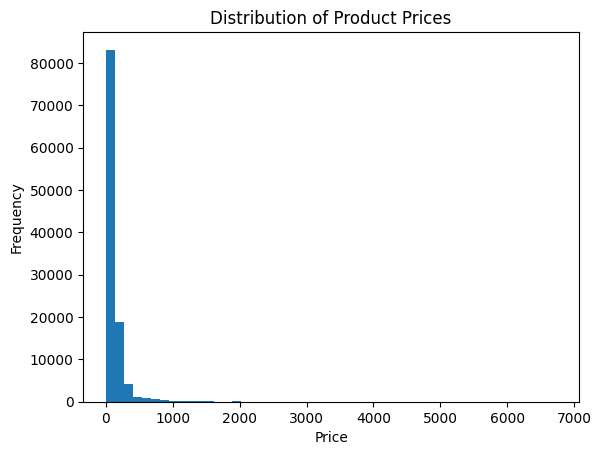

In [33]:
plt.figure()
plt.hist(df_final['price'], bins=50)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Product Prices')
plt.show()

El histograma del precio muestra una alta concentración de observaciones en rangos de precio bajos, con una cola extendida hacia valores más elevados. Esta distribución asimétrica sugiere que la mayoría de los productos vendidos son de bajo precio, mientras que un número reducido corresponde a productos de mayor valor.

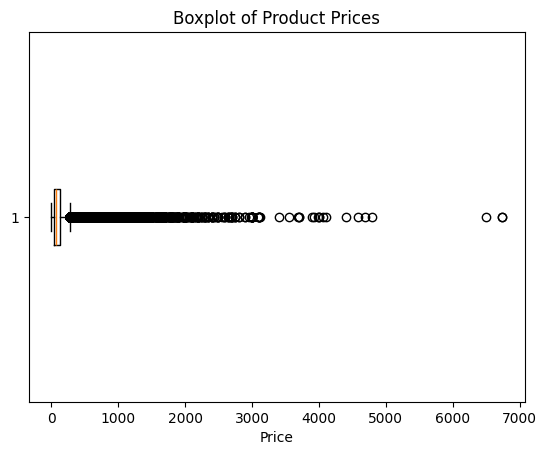

In [34]:
plt.figure()
plt.boxplot(df_final['price'], vert=False)
plt.xlabel('Price')
plt.title('Boxplot of Product Prices')
plt.show()

El boxplot del precio permite identificar la presencia de valores atípicos, representados por observaciones alejadas del rango intercuartílico. Estos valores no se consideran errores, sino una característica esperable en un entorno de comercio electrónico con productos de distinto valor económico.

In [35]:
Q1 = df_final['price'].quantile(0.25)
Q3 = df_final['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_price = df_final[
    (df_final['price'] < lower_bound) |
    (df_final['price'] > upper_bound)
]

outliers_price.shape[0]

8162

La identificación de valores atípicos se realizó mediante el método del rango intercuartílico (IQR), lo que permitió cuantificar la cantidad de observaciones extremas sin excluirlas del análisis, preservando así la información real del mercado.

### freight_value

In [36]:
df_final['freight_value'].describe()

count    110197.000000
mean         19.948598
std          15.698136
min           0.000000
25%          13.080000
50%          16.260000
75%          21.150000
max         409.680000
Name: freight_value, dtype: float64

Las estadísticas descriptivas del costo de envío evidencian una elevada dispersión y un amplio rango de valores, lo que refleja la variabilidad logística inherente al comercio electrónico.

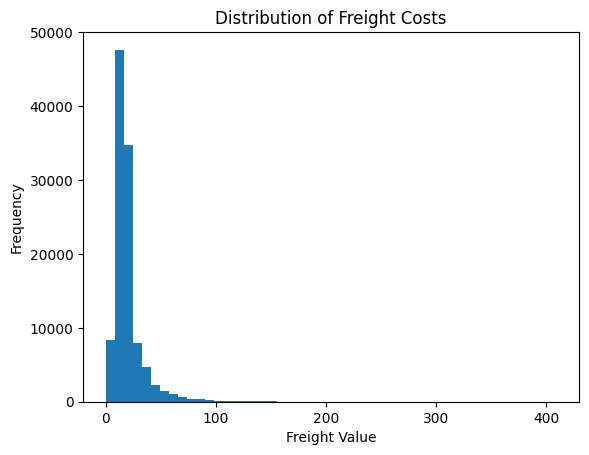

In [37]:
plt.figure()
plt.hist(df_final['freight_value'], bins=50)
plt.xlabel('Freight Value')
plt.ylabel('Frequency')
plt.title('Distribution of Freight Costs')
plt.show()

El histograma del costo de envío muestra una fuerte concentración de valores bajos y una cola prolongada hacia valores elevados, indicando una distribución altamente asimétrica. Este comportamiento es consistente con diferencias logísticas entre productos y ubicaciones.

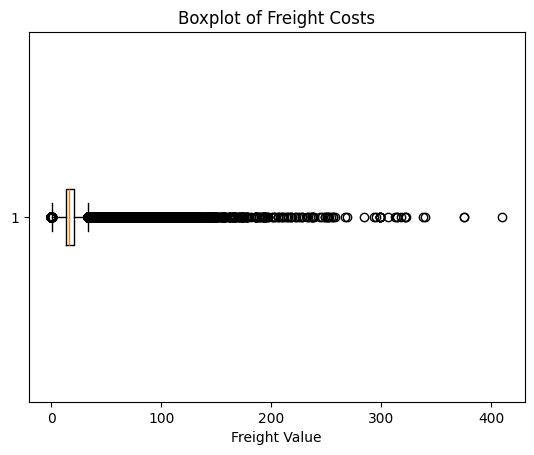

In [38]:
plt.figure()
plt.boxplot(df_final['freight_value'], vert=False)
plt.xlabel('Freight Value')
plt.title('Boxplot of Freight Costs')
plt.show()

El boxplot del costo de envío permite visualizar la elevada variabilidad del flete, así como la presencia de valores extremos, los cuales representan envíos con mayores costos logísticos y no errores de registro.

In [39]:
df_final['freight_value'].std()

np.float64(15.698136099019957)

La desviación estándar del costo de envío refuerza la existencia de una alta variabilidad, lo que sugiere heterogeneidad en las condiciones de entrega.

### week

Analizando la columna week, podemos obtener cuantas semanas de información contiene nuestro dataframe, así como el valor mínimo, máximo en el rango de las fechas



In [40]:
demanda_semanal["week"].nunique()

91

In [41]:
demanda_semanal["week"].describe()

count                            77713
mean     2017-12-27 06:19:33.765007104
min                2016-09-12 00:00:00
25%                2017-09-04 00:00:00
50%                2018-01-15 00:00:00
75%                2018-05-07 00:00:00
max                2018-08-27 00:00:00
Name: week, dtype: object

### weekly_quantity

Con analizando la columna weekly_quantity podemos obtener la cantidad de venta semanal de cada producto, así como la cantidad de ventas finales

In [42]:
demanda_semanal["weekly_quantity"].sum()

np.int64(110197)

De lo anterior podemos observar que durante todo el periodo de la información obtenida del dataframe se han tenido la venta de **110,197 objetos**.

In [43]:
demanda_semanal["weekly_quantity"].describe()

count    77713.000000
mean         1.418000
std          1.381524
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         59.000000
Name: weekly_quantity, dtype: float64

De la información anterior podemos ver que las ventas han ido desde 1 producto hasta un máximo de 59 en la mejor semana

### product_category

Sobre las categorías de los productos analizamos con cuantas contamos en nuestro dataframe

In [44]:
df_final["product_category_name_english"].nunique()

72

Podemos también obtener la cantidad de registros que tenemmos por cada categoría en el dataframe, esto nos permite sabes cuales categorías tienen mayor y menor demanda en general.

In [45]:
# Contar los registros totales de cada categoría de producto

category_counts = df_final["product_category_name_english"].value_counts()
display(category_counts)

product_category_name_english
bed_bath_table               10953
health_beauty                 9465
sports_leisure                8431
furniture_decor               8160
computers_accessories         7644
                             ...  
arts_and_craftmanship           24
cds_dvds_musicals               14
la_cuisine                      14
fashion_childrens_clothes        7
security_and_services            2
Name: count, Length: 72, dtype: int64

### Análisis Bivariante

### week vs weekly_quantity

Con base en estas dos columnas podemos obtener la venta total de productos por semana

In [46]:
ventas_semanales_totales = (
    demanda_semanal
    .groupby('week')
    .agg(total_weekly_quantity=('weekly_quantity', 'sum'))
    .reset_index()
)

ventas_semanales_totales.head(5)

,week,total_weekly_quantity
0,2016-09-12,3
1,2016-10-03,276
2,2016-10-10,37
3,2016-12-19,1
4,2017-01-02,45


### product_category_name_english vs weekly_quantity

Del análisis de todas las ventas podemos obtener cuales son las categorías que tienen mayor demanda.

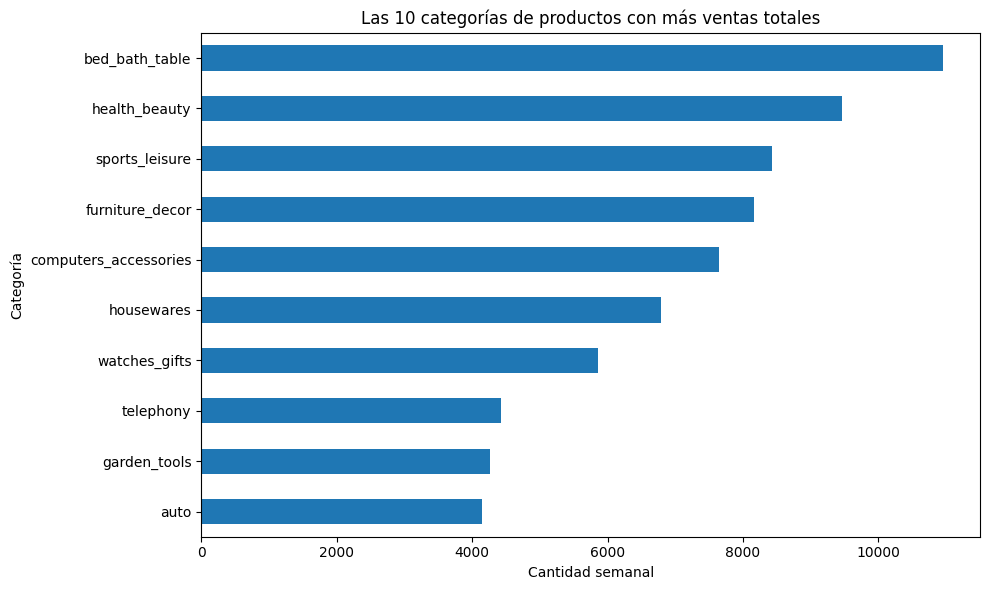

In [47]:
plt.figure(figsize=(10, 6))
agrupado_semanal.sort_values().plot(kind='barh')
plt.title('Las 10 categorías de productos con más ventas totales')
plt.xlabel('Cantidad semanal')
plt.ylabel('Categoría')
plt.tight_layout()
plt.show()

### Week vs product_category

¿Podemos revisar la evolución de la demanda de una categoría por semana?
Tomemos como ejemplo la categoría 'health_beauty'

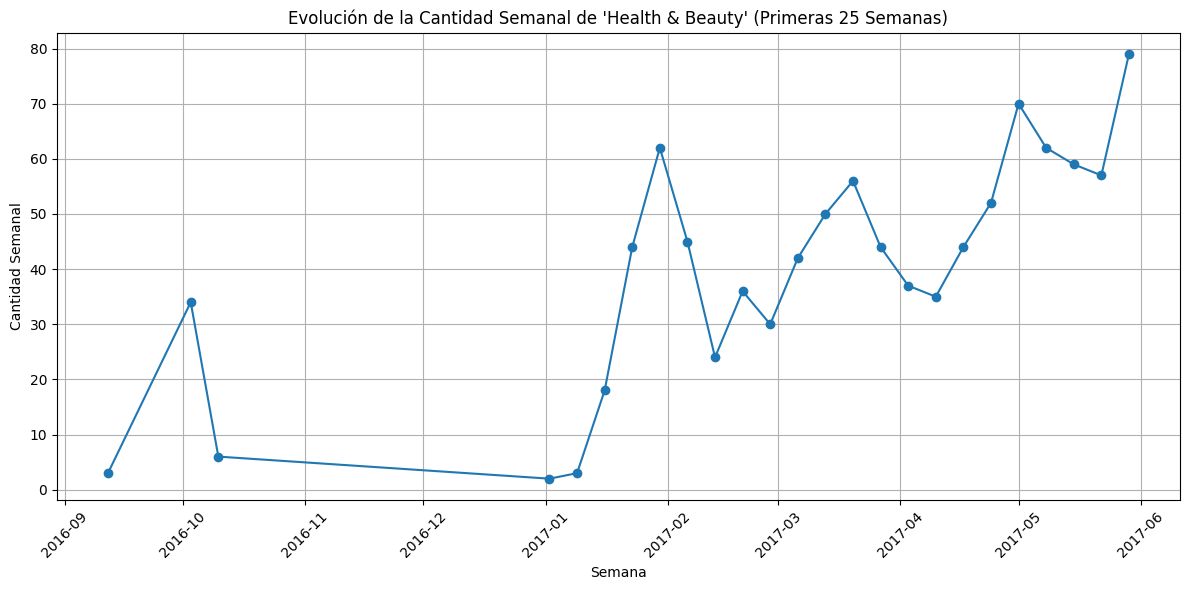

In [48]:
# Filtrar el dataframe para la categoría 'health_beauty'
health_beauty_df = demanda_semanal[
    demanda_semanal["product_category_name_english"] == "health_beauty"
]

# Agrupar por semana y sumamos la cantidad semanal
health_beauty_weekly_demand = (
    health_beauty_df.groupby("week")["weekly_quantity"].sum().reset_index()
)

# Seleccionamos los primeros 25 valores de week
health_beauty_weekly_demand_top25 = health_beauty_weekly_demand.head(25)

# Graficar la evolución de la cantidad semanal
plt.figure(figsize=(12, 6))
plt.plot(
    health_beauty_weekly_demand_top25["week"],
    health_beauty_weekly_demand_top25["weekly_quantity"],
    marker="o"
)
plt.title("Evolución de la Cantidad Semanal de 'Health & Beauty' (Primeras 25 Semanas)")
plt.xlabel("Semana")
plt.ylabel("Cantidad Semanal")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Gracias a esta gráfica podemos ver en cambio de los valores de demanda de una categoría en específico dentro de un periodo de tiempo específico.
De igual forma podemos hacer este análisis para las distintas categorías

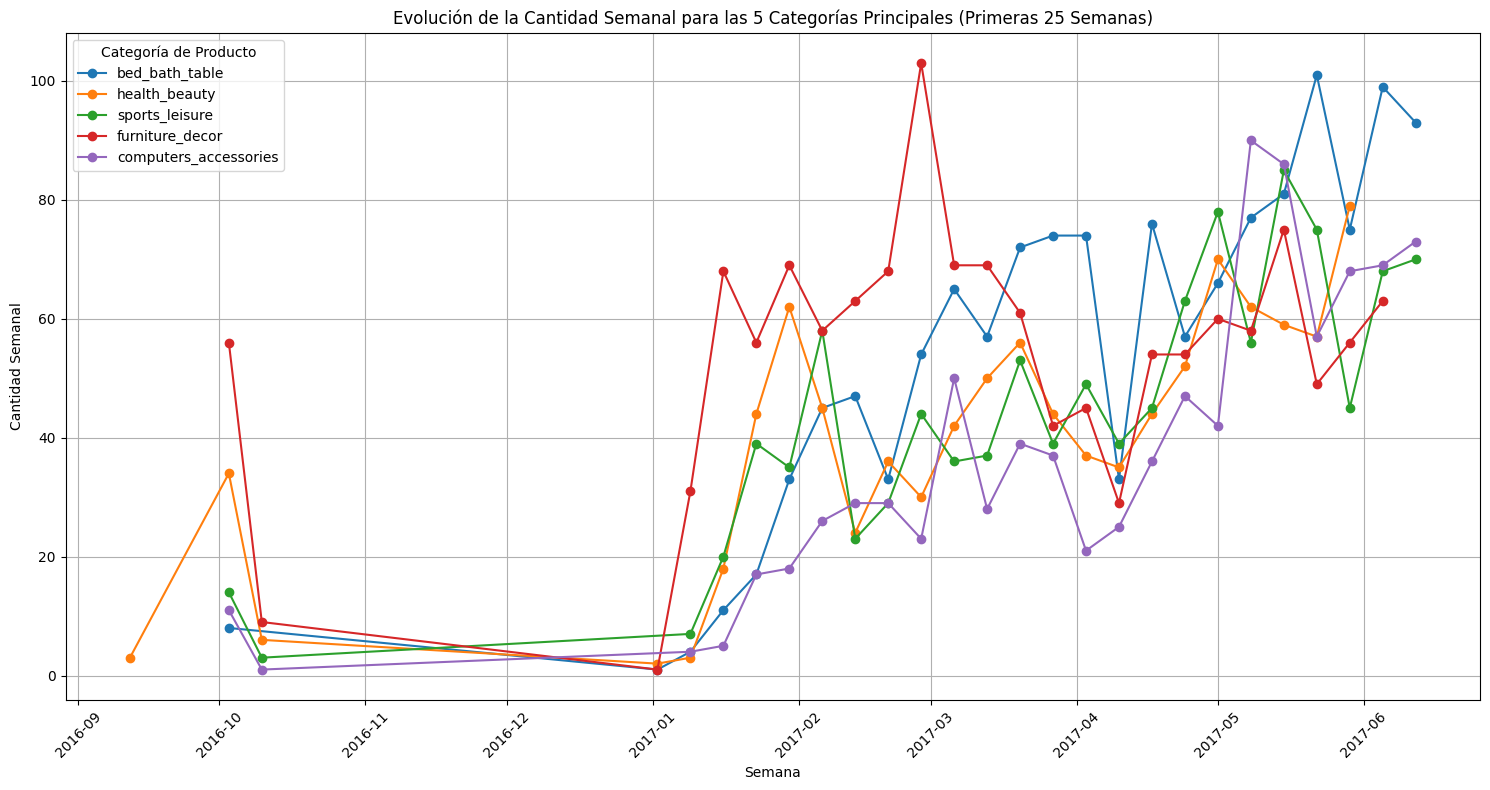

In [49]:
# Seleccionamos las 5 categorías de productos con más ventas totales
top_5_categories = agrupado_semanal.head(5).index.tolist()

plt.figure(figsize=(15, 8))

for category in top_5_categories:
    # Filtrar el dataframe para la categoría actual
    category_df = demanda_semanal[
        demanda_semanal["product_category_name_english"] == category
    ]

    # Agrupar por semana y sumamos la cantidad semanal
    category_weekly_demand = (
        category_df.groupby("week")["weekly_quantity"].sum().reset_index()
    )

    # Seleccionamos los primeros 25 valores de week
    category_weekly_demand_top25 = category_weekly_demand.head(25)

    # Graficar la evolución de la cantidad semanal para la categoría actual
    plt.plot(
        category_weekly_demand_top25["week"],
        category_weekly_demand_top25["weekly_quantity"],
        marker="o",
        label=category
    )

plt.title("Evolución de la Cantidad Semanal para las 5 Categorías Principales (Primeras 25 Semanas)")
plt.xlabel("Semana")
plt.ylabel("Cantidad Semanal")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(title="Categoría de Producto")
plt.tight_layout()
plt.show()

#### Price vs Product Category Name English

¿Existen diferencias significativas en los precios de los productos según su categoría?

In [50]:
df_final.groupby('product_category_name_english')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
product_category_name_english,,,,,,,,
agro_industry_and_commerce,206.0,342.553883,424.010065,12.99,35.00,243.75,420.00,2990.00
air_conditioning,289.0,184.510588,189.799072,10.90,75.90,139.99,199.00,1599.00
art,197.0,120.087817,458.705181,5.35,55.00,99.90,99.99,6499.00
arts_and_craftmanship,24.0,75.583750,73.997815,9.80,19.60,44.90,127.24,289.49
audio,362.0,139.697790,159.988774,14.90,19.90,89.00,175.00,598.99
...,...,...,...,...,...,...,...,...
tablets_printing_image,83.0,90.703735,93.096747,14.90,54.90,99.00,99.00,889.99
telephony,4430.0,69.945876,133.891395,5.00,21.99,29.99,49.00,2428.00
toys,4030.0,116.944536,131.586770,4.90,45.99,79.90,129.90,1699.99


El análisis descriptivo por categoría permite comparar las medidas de tendencia central y dispersión del precio entre los distintos tipos de productos. Este resumen evidencia diferencias relevantes en los niveles de precio promedio y en la variabilidad entre categorías, lo que sugiere una estructura de precios diferenciada según el tipo de producto.

<Figure size 1200x600 with 0 Axes>

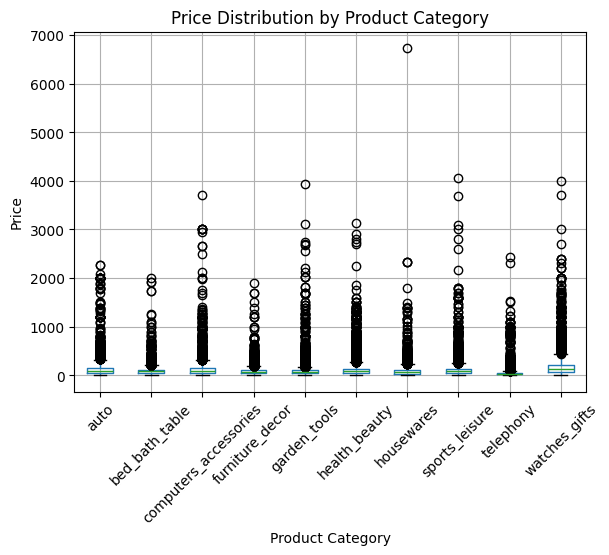

In [51]:
top_categories = df_final['product_category_name_english'].value_counts().head(10).index

df_top = df_final[df_final['product_category_name_english'].isin(top_categories)]

plt.figure(figsize=(12,6))
df_top.boxplot(column='price', by='product_category_name_english', rot=45)
plt.title('Price Distribution by Product Category')
plt.suptitle('')
plt.xlabel('Product Category')
plt.ylabel('Price')
plt.show()

El boxplot de precios por categoría permite visualizar claramente las diferencias en la distribución de precios entre los distintos tipos de productos. Se observan categorías con medianas significativamente más altas, así como diferencias en la dispersión y presencia de valores extremos, lo que confirma que el precio depende en gran medida de la categoría del producto.

In [52]:
mean_price_category = (
    df_final.groupby('product_category_name_english')['price']
    .mean()
    .sort_values(ascending=False)
)

mean_price_category.head(10)

product_category_name_english
computers                                1098.915276
small_appliances_home_oven_and_coffee     638.213151
home_appliances_2                         467.333117
agro_industry_and_commerce                342.553883
musical_instruments                       283.127097
small_appliances                          277.741824
fixed_telephony                           216.922392
construction_tools_safety                 211.875519
watches_gifts                             199.040276
furniture_bedroom                         184.968932
Name: price, dtype: float64

El análisis bivariante entre el precio y la categoría del producto demuestra la existencia de diferencias significativas en los niveles de precios según el tipo de producto. Algunas categorías presentan precios medianos y promedios considerablemente más elevados, así como mayor dispersión, lo que refleja una estructura de precios diferenciada propia de un catálogo heterogéneo. Estos resultados confirman que la categoría del producto es un factor relevante en la determinación del precio.

#### Freight Value vs Product Category Name English


¿Existen diferencias en los costos de envío según el tipo de producto?

In [53]:
df_final.groupby('product_category_name_english')['freight_value'].describe()

,count,mean,std,min,25%,50%,75%,max
product_category_name_english,,,,,,,,
agro_industry_and_commerce,206.0,27.365049,22.254381,7.39,15.1400,23.495,30.1500,194.55
air_conditioning,289.0,22.598581,14.151886,6.58,15.2300,18.390,25.8400,115.43
art,197.0,19.432640,17.397947,7.39,12.2300,15.100,23.2800,227.66
arts_and_craftmanship,24.0,15.422083,12.267814,7.39,9.1000,12.865,15.7975,68.72
audio,362.0,15.703646,6.501574,4.25,12.6975,15.230,18.2300,52.67
...,...,...,...,...,...,...,...,...
tablets_printing_image,83.0,14.773494,5.723715,1.71,9.4400,14.860,16.3900,34.49
telephony,4430.0,15.652910,7.824388,0.01,11.0200,15.100,18.2300,121.22
toys,4030.0,18.802625,13.306924,0.01,12.8375,16.110,19.6875,193.76


El análisis descriptivo del costo de envío por categoría permite comparar las medidas de tendencia central y dispersión entre los distintos tipos de productos. Los resultados muestran diferencias relevantes tanto en los costos promedio como en la variabilidad del flete, lo que sugiere que el tipo de producto influye en las condiciones logísticas de entrega.

<Figure size 1200x600 with 0 Axes>

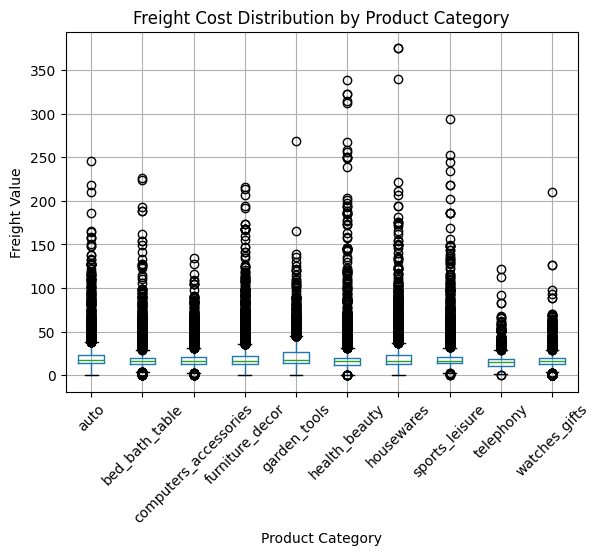

In [54]:
top_categories = df_final['product_category_name_english'].value_counts().head(10).index
df_top = df_final[df_final['product_category_name_english'].isin(top_categories)]

plt.figure(figsize=(12,6))
df_top.boxplot(column='freight_value', by='product_category_name_english', rot=45)
plt.title('Freight Cost Distribution by Product Category')
plt.suptitle('')
plt.xlabel('Product Category')
plt.ylabel('Freight Value')
plt.show()

El boxplot del costo de envío por categoría evidencia diferencias claras en la distribución del flete entre los distintos tipos de productos. Algunas categorías presentan costos medianos más elevados y mayor dispersión, lo que puede estar asociado a factores como peso, volumen o complejidad logística.

In [55]:
mean_freight_category = (
    df_final.groupby('product_category_name_english')['freight_value']
    .mean()
    .sort_values(ascending=False)
)

mean_freight_category.head(10)

product_category_name_english
computers                                  48.570955
home_appliances_2                          44.392078
furniture_mattress_and_upholstery          42.739730
kitchen_dining_laundry_garden_furniture    42.120401
furniture_bedroom                          42.013786
office_furniture                           40.202068
small_appliances_home_oven_and_coffee      36.388219
furniture_living_room                      35.746202
signaling_and_security                     32.880914
industry_commerce_and_business             28.605774
Name: freight_value, dtype: float64

El análisis bivariante entre el costo de envío y la categoría del producto demuestra que los gastos logísticos varían significativamente según el tipo de producto. Algunas categorías presentan costos de envío más elevados y mayor dispersión, lo que refleja diferencias en peso, volumen y complejidad de distribución. Estos resultados evidencian la importancia de considerar la categoría del producto en la gestión logística y la planificación de costos.

### Price vs Product ID

¿Los productos con mayor precio se compran con menor frecuencia?

In [62]:
frecuencia_producto = (
    df_final.groupby('product_id')
    .size()
    .reset_index(name='purchase_frequency')
)

df_price_freq = df_final[['product_id', 'price']].drop_duplicates()
df_price_freq = df_price_freq.merge(frecuencia_producto, on='product_id')

Para analizar la relación entre precio y frecuencia de compra, se calculó el número de veces que cada producto fue adquirido, utilizando el identificador del producto. Posteriormente, se asoció esta frecuencia con el precio correspondiente de cada producto.

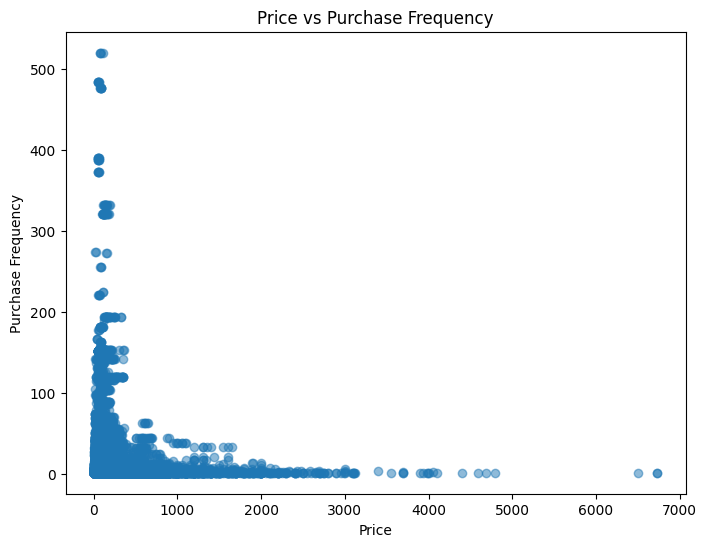

In [63]:
plt.figure(figsize=(8,6))
plt.scatter(df_price_freq['price'], df_price_freq['purchase_frequency'], alpha=0.5)
plt.xlabel('Price')
plt.ylabel('Purchase Frequency')
plt.title('Price vs Purchase Frequency')
plt.show()

El diagrama de dispersión permite visualizar la relación entre el precio del producto y su frecuencia de compra. Se observa que los productos con precios más bajos tienden a concentrar una mayor frecuencia de compra, mientras que los productos de mayor precio presentan, en general, una menor cantidad de ventas.

In [64]:
df_price_freq['price_range'] = pd.qcut(
    df_price_freq['price'],
    q=4,
    labels=['Low', 'Medium-Low', 'Medium-High', 'High']
)

df_price_freq.groupby('price_range')['purchase_frequency'].mean()

C:\Users\tessa\AppData\Local\Temp\ipykernel_1824\3378130338.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_price_freq.groupby('price_range')['purchase_frequency'].mean()


price_range
Low            4.940877
Medium-Low     7.237599
Medium-High    9.621138
High           6.348590
Name: purchase_frequency, dtype: float64

El análisis bivariante entre el precio y la frecuencia de compra sugiere una relación inversa entre ambas variables. En general, los productos de mayor precio tienden a ser adquiridos con menor frecuencia, mientras que los productos más económicos concentran un mayor volumen de compras. Este comportamiento es consistente con patrones de consumo habituales en comercio electrónico y aporta información relevante para estrategias de precios y gestión de inventario.

### Análisis Bivariante de Categoría con venta semanal

In [65]:
#Categoria con mayor demanda semanal
top_10_categorias = (
    demanda_semanal
    .groupby("product_category_name_english", as_index=False)
    .agg(total_weekly_quantity=("weekly_quantity", "sum"))
    .sort_values("total_weekly_quantity", ascending=False)
    .head(10)
)
top_10_categorias

,product_category_name_english,total_weekly_quantity
7,bed_bath_table,10953
43,health_beauty,9465
65,sports_leisure,8431
39,furniture_decor,8160
15,computers_accessories,7644
49,housewares,6795
71,watches_gifts,5859
68,telephony,4430
42,garden_tools,4268
5,auto,4140


Para ver el comportamiento de las ventas por categoría, se visualizó el top 10 de las categorías con más productos vendidos en la historia de la data. Siendo “bet_bath_table” la categoría con mayores ventas.

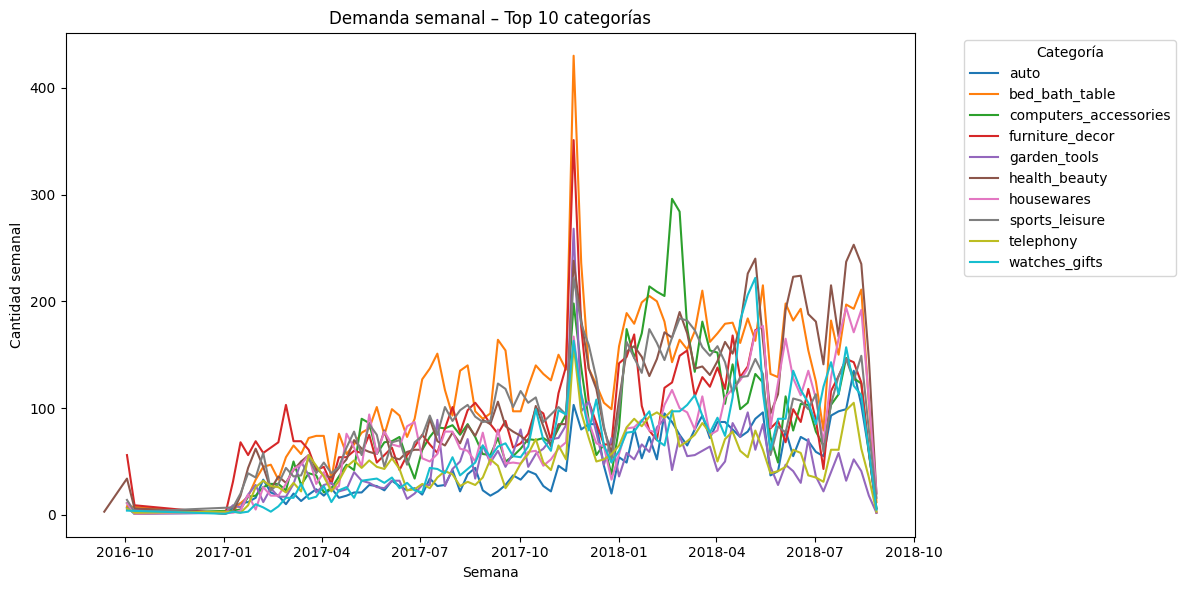

In [66]:
## Serie de tiempo de top 10 Categorias con mayor demanda

lista_top_10_categorias = (top_10_categorias["product_category_name_english"].tolist())
demanda_top_10 = demanda_semanal[demanda_semanal["product_category_name_english"].isin(lista_top_10_categorias)]

demanda_top_10 = (
    demanda_top_10.groupby(["week", "product_category_name_english"],as_index=False)
    .agg(total_weekly_quantity=("weekly_quantity", "sum")).sort_values(by="week")
)

plt.figure(figsize=(12, 6))

for categoria, df_cat in demanda_top_10.groupby("product_category_name_english"):
    plt.plot(
        df_cat["week"],
        df_cat["total_weekly_quantity"],
        label=categoria
    )

plt.xlabel("Semana")
plt.ylabel("Cantidad semanal")
plt.title("Demanda semanal – Top 10 categorías")
plt.legend(title="Categoría", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

También se hizo una gráfica de líneas de éstas 10 categorías para ver su comportamiento a través del tiempo. En el gráfico se observa que, si bien “bed_bath_table” es la categoría con mayores ventas históricas, no mantiene de forma constante esta posición a lo largo de todas las semanas. Algunas categorías, como “computers_accessories”, presentan picos de ventas más elevados en determinados periodos. Asimismo, se aprecia que entre octubre de 2017 y abril de 2018 existe una semana en la que la mayoría de las categorías registraron un incremento significativo en las ventas. Con este grafico podemos ver que para identificar patrones y tendencias de demanda es importante tomar en cuenta la segmentación de los productos. 